In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy import stats

C:\Users\agrog\AppData\Local\Temp\ipykernel_26976\705250060.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Li, Bramley, & Gureckis (2021)
===

Trying to recreate the suspense modelling from Li, Bramley, and Gureckis (2021).

I'll copy over some of their code from OSF ([link](https://osf.io/zsjk8)), and rewrite some for my own clarity

The minimal amount to get their code working and simulating suspense is:
- A belief model: the player's perceived probability of success
- A suspense model: the metric that quantifies suspense as a function of belief

Notes:

- The authors are inconsistent in whether the bust condition is inclusive of bounds: sometimes they count 21 as bust, sometimes they dont
  - Here, we'll follow the blackjack rule of 21 is *not* bust, to keep understanding consistent for players

In [2]:
# Generate a sequence of pairs

def genPairSequence(theGame: dict) -> dict:
    # Deconstruct into upper and lower bounds
    upperBound, lowerBound = theGame['bounds']

    # Define callbacks that we'll use to check if the player is bust or not
    if theGame['isBust']:
        # Check if score is above upperBound or below lowerBound
        gameDone = lambda x: x > upperBound or x < lowerBound
    else:
        gameDone = lambda x: False

    pairSequence = []
    for n in range(theGame['nmax']):
        # Sample from the deck twice, without replacement - i.e. draw 2 unique cards (although their value CAN be equal)
        pairSequence.append(np.random.choice(theGame['deck'], 2, replace=False))

        # Check if the player is bust after drawing a new pair - note that they'll always get the first card in the pair as it's fixed
        if gameDone(sum(p[0] for p in pairSequence)):
            print('Bust')
            break

    theGame['pairSequence'] = np.array(pairSequence)
    theGame['isWin'] = checkIfWon([pr[0] for pr in pairSequence], theGame)

    return theGame

def checkIfWon(cards: list, theGame: dict) -> int:
    """
    Given the current list of cards, check if the player has gone bust.
    Returns:
        : -1 for lost now
        : +1 for won now
        : 0 for other

    Note that elsewhere, the authors use 0/1/0.5 for lost/win/unknown

    """
    # Deconstruct bounds
    upperBound, lowerBound = theGame['bounds']
    # Check if the player is bust - NB: this counts bust as inclusive of the upperBound, unlike in actual Blackjack
    bust = (sum(cards) > upperBound) or (sum(cards) < lowerBound)
    # Define a default value for if they haven't won or lost yet
    outcome = 0

    if bust:
        # if the player is bust, or if they've exceeded the max number of draws
        # I have a feeling this check is actually redundant, but I'll leave it in for consistency with the authors
        if theGame['isBust'] or (not theGame['isBust'] and len(cards) == theGame['nmax']):
            # Lost
            outcome = -1
    else:
        # If all cards have been drawn without going bust
        if len(cards) == theGame['nmax']:
            # Win
            outcome = 1

    return outcome


In [3]:
# --- Belief models ---

def getWinProbability(theGame: dict) -> dict:
    """
    Compute the probability of winning for every card drawn

    This generates a list called `probOfWinning`, which is indexed with the number of remaining cards.
    It can be interpreted as:
        - Given how many cards you have left to draw,
        - Given your current store (the series index), the value gives your probability of winning

    Eg: If you have drawn 1 card, and have 4 cards remaining, look at probOfWinning[4].
    This has indices of minimumScore -> maximumScore, a list of all scores you may have from your first draw.
    If you drew a -3 on your first hand, then probOfWinning[4][-3] is the probability you'll win overall
    
    Eg 2: If you have drawn 4 cards and have 1 card remnaining, and your total score is 3, your probability of winning is:
    probOfWinning[1][3] = 1.0 :: since you can't draw a card greater than 18 (21-3=18).
    """
    # Create some local references to params
    nmax = theGame['nmax']
    upperBound, lowerBound = theGame['bounds']
    isBust = theGame['isBust']
    # Get all unique-valued cards in deck, and return the number of occurences of each value
    uniqueCards, cardCounts = np.unique(theGame['deck'], return_counts=True)
    # Compute probability of drawing each valued card
    cardProbabilities = cardCounts/sum(cardCounts)
    # Generate the probability distribution over the current deck
    probabilityDist = generateDistribution(theGame)
    # Define a structure for storing probability of winning after drawing the i'th card
    probOfWinning = [[] for kk in range(nmax + 1)]

    # Make a list of all possible scores
    possibleScores = np.arange(min(uniqueCards)*nmax, max(uniqueCards)*nmax+1)
    # From the possible scores, compute which are within bounds and allowed (1) and which are out of bounds (0)
    canWin = [int(score < upperBound and score > lowerBound) for score in possibleScores]
    probOfWinning[0] = pd.Series(canWin, index=possibleScores)


    for nmore in range(1, nmax+1):
        N = nmax - nmore
        # Again compute all possible scores from here
        possibleScores = np.arange(min(uniqueCards)*N, max(uniqueCards)*N+1)
        pWin = []
        # iterate over all possible scores
        for score in possibleScores:
            # Check bust condition
            if isBust:
                if score > upperBound or score < lowerBound:
                    pWin.append(0)
                    continue
                else:
                    probOfWin = 0
                    for ix, cardVal in enumerate(uniqueCards):
                        # sum the probabilities of drawing card ix and times by if this is within bounds (i.e. 0 or 1)
                        probOfWin += cardProbabilities[ix] * probOfWinning[nmore-1][score + cardVal]
                    pWin.append(probOfWin)
            else:
                # compute the probability of the sum of all remaining cards
                psum = probabilityDist[nmore-1] # the probability distribution given the remaining possible draws
                # for each possible remaining score that can be obtained, check if current score + poss remaining score is within bounds
                thisProb = max(
                                min(
                                    sum(
                                        [psum[smr] for smr in psum.index.values if score + smr < upperBound and score + smr > lowerBound]), 
                                    1), 
                                0)
                pWin.append(thisProb)
        # and store computed probabilities
        probOfWinning[nmore] = pd.Series(pWin, index=possibleScores)
        
    # Note that probOfWinning is indexed by number of remaining cards, not number drawn so far
    theGame['probOfWinning'] = probOfWinning

    return theGame



def generateDistribution(theGame: dict) -> list:
    """
    Produces a probability distribution of all possible scores under the given deck of cards
    Returns a list of pandas series, indexed by the draw number - 1
    """
    nmax = theGame['nmax']
    uniqueCards, cardCounts = np.unique(theGame['deck'], return_counts=True)
    cardProbabilities = cardCounts/sum(cardCounts)
    sumProbs = []
    sumProbs.append(pd.Series(cardProbabilities, index=uniqueCards))

    # Starting from 2 drawn cards, up to and inlcuding the maximum num that can be drawn
    for N in range(2, nmax+1):
        # Compute the lowest and highest possible values, and arange as a list of the values inbetween
        possibleScores = np.arange(min(uniqueCards)*N, max(uniqueCards)*N+1)
        # Create a pandas series of structure final-score : 0.0
        psum = pd.Series(np.zeros(len(possibleScores)), index=possibleScores)
        # Take the probabilities of drawing the card at the previous time step:
        psum0 = sumProbs[N-2]

        # --- For each possible total score after drawing N hands, compute the probability of getting that score ---
        # Iterate over all unique values that could be drawn
        for ix, cardVal in enumerate(uniqueCards):
            # iterate over the probability sums at the previous timestep (i.e. card draw)
            for x0 in psum0.index.values:
                psum[cardVal+x0] += psum0[x0]*cardProbabilities[ix]

        # Store the new probability sums 
        sumProbs.append(psum)

    return sumProbs

In [80]:
uniqueCards, cardCounts = np.unique(theGame['deck'], return_counts=True)
cardProbabilities = cardCounts/sum(cardCounts)
sumProbs = []
sumProbs.append(pd.Series(cardProbabilities, index=uniqueCards))
nmax=5

for N in range(2, nmax+1):
    sums = np.arange(min(uniqueCards)*N, max(uniqueCards)*N+1)
    psum = pd.Series(np.zeros(len(sums)), index=sums)
    # Take the probabilities of drawing the card at the previous time step:
    psum0 = sumProbs[N-2]
    # Iterate over all unique values that could be drawn
    for ix, cardVal in enumerate(uniqueCards):
        # iterate over the probability sums at the previous timestep
        for x0 in psum0.index.values:
            # For each possible total score after drawing N hands, compute the probability of getting that score
            psum[cardVal+x0] += psum0[x0]*cardProbabilities[ix]

    sumProbs.append(psum)


upperBound, lowerBound = theGame['bounds']
isBust = theGame['isBust']
nmax = 5

probOfWinning = [[] for kk in range(nmax + 1)]

possibleScores = np.arange(min(uniqueCards)*nmax, max(uniqueCards)*nmax+1)
# From the possible scores, compute which are within bounds and allowed (1) and which are out of bounds (0)
canWin = [int(score < upperBound and score > lowerBound) for score in possibleScores]
probOfWinning[0] = pd.Series(canWin, index=possibleScores)


for nmore in range(1, nmax+1):
    N = nmax - nmore
    # Again compute all possible scores from here
    possibleScores = np.arange(min(uniqueCards)*N, max(uniqueCards)*N+1)
    pWin = []
    # iterate over all possible scores
    for score in possibleScores:
        # Check bust condition
        if isBust:
            if score > upperBound or score < lowerBound:
                pWin.append(0)
                continue
            else:
                probOfWin = 0
                for ix, cardVal in enumerate(uniqueCards):
                    # sum the probabilities of drawing card ix and times by if this is within bounds (i.e. 0 or 1)
                    probOfWin += cardProbabilities[ix] * probOfWinning[nmore-1][score + cardVal]
                pWin.append(probOfWin)
        else:
            # compute the probability of the sum of all remaining cards
            psum = sumProbs[nmore-1] # the probability distribution given the remaining possible draws
            # for each possible remaining score that can be obtained, check if current score + poss remaining score is within bounds
            thisProb = max(
                            min(
                                sum(
                                    [psum[smr] for smr in psum.index.values if score + smr < upperBound and score + smr > lowerBound]), 
                                1), 
                            0)
            pWin.append(thisProb)
    # and store computed probabilities
    probOfWinning[nmore] = pd.Series(pWin, index=possibleScores)
    
# Note that probOfWinning is indexed by number of remaining cards, not number drawn so far
theGame['probOfWinning'] = probOfWinning

In [4]:
## -- Some helper functions

def beliefProbability(currentCard: int, prevCards: list, theGame: dict) -> float:
    """
    The belief that the player will immediately win

    Inputs:
        - currentCard: the value of the current (comparison) card
        - prevCards: A 1D list of the previously drawn card values
        - theGame: dict of all game data

    NB: the checkIfWon() function gives win/lose/unknown as 1/-1/0, 
    and here we transform it into 1/0/0.5
    """
    return (checkIfWon(prevCards + [currentCard], theGame) + 1)/2

def computeEntropy(p1, base=None):
    p1 = np.round(p1, 4)
    if np.size(p1) == 1:
        pdis = [p1, 1-p1]
    else:
        pdis = p1
    return stats.entropy(pdis, base=base)

In [5]:
# Compute suspense

def computeSuspense(theGame: dict, suspenseModels: list = ['cardDifference', 'infoGain', 'full']) -> dict:
    """
    Wrapper for iterating over all specified models of suspense and computing the suspenses for each
    Stores the lists in a dict within `theGame`, key: 'suspenses'
    """
    # If the probabilities of winning haven't been computed, do so
    if 'probOfWinning' not in theGame:
        theGame = getWinProbability(theGame)
    
    # Get local ref to the card pairs
    pairs = theGame['pairSequence']

    # Make a dict to store the suspense sequences for each suspense model
    suspenses = {}
    for model in suspenseModels:
        # Initialise with a list of length number of cards
        suspenses[model] = [[] for k in range(len(pairs))]

    # ---- Compute suspense for each model ---- #
        
    # For each card to be played
    for n in range(len(pairs)):
        pair = pairs[n]
        for model in suspenseModels:
            suspenses[model][n] = suspenseFns(pair, pairs[:n, 0], model, theGame)
    
    theGame['suspense'] = suspenses

    return theGame

def suspenseFns(pair: list, prevCards: list, model: str, theGame: dict) -> list:
    # get bounds
    upperBound, lowerBound = theGame['bounds']
    probOfWinning = theGame['probOfWinning']
    nmore = theGame['nmax'] - len(prevCards)
    currentScore = sum(prevCards)

    # Check model type and compute suspense based on that model
    # model types are: winnow, carddiff, tobnd, plose, almostlose, uncertainty, infogain, L2, L1, L1biased, KL, Hellinger

    if model == "winNow":
        ## The probability that the player will win immediately, given the current cards
        ## This is Ely suspense on the belief that they'll win immediately
        # Takes the two cards in front of them, computes the probability of winning for each, and takes the variance
        p0 = beliefProbability(pair[0], prevCards, theGame)
        p1 = beliefProbability(pair[1], prevCards, theGame)
        suspense = (p0 - p1)**2

    elif model == 'cardDifference':
        ## The ratio of the difference in comparison cards to the maximum difference
        maxDifference = max(theGame['deck']) - min(theGame['deck'])
        suspense = abs(pair[0] - pair[1])/maxDifference

    elif model == "toBoundary":
        ## Check which is closest to a boundary - i.e. either upper or lower bound - of the two cards
        suspense = np.min(
            [np.min(abs(pair - upperBound)), np.min(abs(pair - lowerBound))]
            )
        suspense = np.exp(-suspense/10) # NB: this prohibits the value from being 0

    else:
        # models using longer-term belief - set up the probabilities
        p0 = probOfWinning[nmore - 1][currentScore + pair[0]]
        p1 = probOfWinning[nmore - 1][currentScore + pair[1]]
        # Compute the win belief - rounded to either 1 or 0 - given the two cards drawn
        probabilityNow = int(0.5 * (p0 + p1)*1e5)/1e5 # I'm assuming the 1e5 is to reduce floating point errors

        if model == "probLose":
            ## Simply the opposite of the probability of winning
            suspense = 1 - probabilityNow
        
        elif model == "uncertainty":
            ## The Shannon entropy of the average win belief
            suspense = computeEntropy(probabilityNow) / computeEntropy(0.5) # Note, does this need to include the base? It's using base e as default

        elif model == "informationGain":
            suspense = (2 * computeEntropy(probabilityNow) - (computeEntropy(p0) + computeEntropy(p1)))
            maxSuspense = (2*computeEntropy(0.5) - (computeEntropy(0) + computeEntropy(1)))
            suspense = suspense/maxSuspense

        elif model == "L2":
            ## Ely suspense on complete beliefs
            suspense = (p0-p1)**2

        elif model == "L1":
            ## Ely suspense with L1 distance
            suspense = np.abs(p0-p1)

        elif model == "L1Biased":
            ## L1 distance with a weighting and offset
            p0s = 0.6*p0 + 0.2
            p1s = 0.6*p1 + 0.2
            suspense = np.abs(p0s-p1s)

        elif model == "KL":
            ## Kullback-Leibler divergence
            suspense = stats.entropy([p0, 1-p0], [probabilityNow, 1-probabilityNow]) + stats.entropy([p1, 1-p1], [probabilityNow, 1-probabilityNow])
            maxSuspense = stats.entropy([0, 1], [0.5, 0.5])*2
            suspense = suspense / maxSuspense

        elif model == "Hellinger":
            suspense = np.sqrt(np.sum(
                (np.sqrt([p0, 1-p0]) - np.sqrt([p1, 1-p1]))**2
            )) / (2**0.5)
            maxSuspense = 1
            suspense = suspense/maxSuspense

            # ... more suspenses can be inserted below
        
        else:
            raise ValueError(f"Suspense model name `{model}` not recognised.")

    return suspense



In [119]:
2*computeEntropy(0.5) - (computeEntropy(0) + computeEntropy(1))

1.3862943611198906

In [19]:
# Main
# ----------------------------------------------------
# ## Define game parameters
nmax = 5 # Maximum number of cards that can be drawn
deckSize = 9 # The size of the deck
allowedCards = np.arange(-3, 10) # The possible cards - NB: including negative values! - from which each real deck is sampled
# -----------------------------------------------------

# Define game parameter storage object
theGame = {
    'bounds' : [21, -100], # the upper and lower bounds of the game score - eg: over 21, the player goes bust,
    'nmax' : nmax,
    'deck' : np.random.choice(allowedCards, deckSize), # samples the allowed cards, `deckSize` times, with replacement
    'isBust' : True
    }

# Generate the sequence of card pairs
theGame = genPairSequence(theGame)
theGame['seenCards'] = [i[0] for i in theGame['pairSequence']]

# Compute the suspense for this game
theGame = computeSuspense(theGame,['L1', 'toBoundary', 'probLose', 'uncertainty'])

Bust


In [20]:
seenCards = [i[0] for i in theGame['pairSequence']]
seenCards

[9, 7, 0, 0, 9]

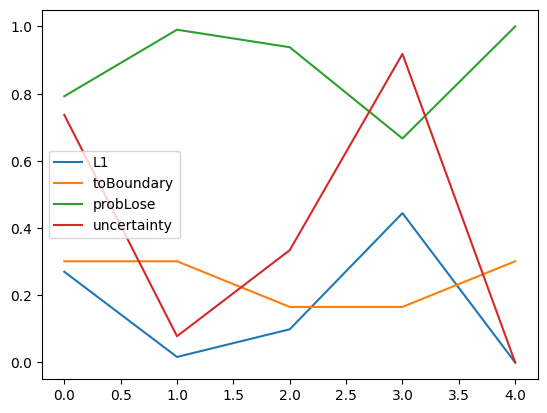

In [21]:
for model in theGame['suspense']:
    plt.plot(list(range(len(theGame['seenCards']))), theGame['suspense'][model], label=model)
plt.legend()
plt.show()


In [104]:
for card, sus, diffSus in zip(theGame['pairSequence'], theGame['suspense']['winNow'], theGame['suspense']['toBoundary']):
    print(f"Draw: {card[0]} -- WinNow: {sus} -- tobnd: {diffSus}")

Draw: 7 -- WinNow: 0.0 -- tobnd: 0.30119421191220214
Draw: 7 -- WinNow: 0.0 -- tobnd: 0.2465969639416065
Draw: 7 -- WinNow: 0.25 -- tobnd: 0.2465969639416065
Draw: -3 -- WinNow: 0.25 -- tobnd: 0.2465969639416065
Draw: -1 -- WinNow: 0.25 -- tobnd: 0.30119421191220214


In [9]:
xs, counts = np.unique(theGame['deck'], return_counts=True)

In [10]:
counts/sum(counts)

array([0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
       0.11111111, 0.22222222, 0.11111111])